In [4]:
import tweepy as tw
import pandas as pd
import re
import nltk
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from nltk import bigrams
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [2]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

In [4]:
def scrape(search_words, date_since, no_of_tweets):
    tweets = tw.Cursor(api.search,
                       q = search_words,
                       lang = "en",
                       since = date_since).items(no_of_tweets)
    cols = ['name', 'tweet', 'retweets', 'location', 'created', 'followers', 'is_user_verified']
    df = pd.DataFrame(columns = cols)
    for tweet in tweets:
        tweet_details = {}
        tweet_details['name'] = tweet.user.screen_name
        tweet_details['tweet'] = tweet.text
        tweet_details['retweets'] = tweet.retweet_count
        tweet_details['location'] = tweet.user.location
        tweet_details['created'] = tweet.created_at.strftime("%d-%b-%Y")
        tweet_details['followers'] = tweet.user.followers_count
        tweet_details['is_user_verified'] = tweet.user.verified
        df = df.append(tweet_details, ignore_index=True)
    return df

In [5]:
search_words = 'FinCEN+Leak'
new_search = search_words + " -filter:retweets"
date_since = '2020-09-19'

In [6]:
d1 = scrape(new_search, date_since, 2000)
d1.shape

(2000, 7)

In [7]:
d1.head(20)

,name,tweet,retweets,location,created,followers,is_user_verified
0,FintechBot,465. News: FinCEN Files leak and Natwest carbo...,0,"Sheffield, UK",28-Sep-2020,12023,False
1,FintechBot,465. News: FinCEN files leak and Natwest carbo...,0,"Sheffield, UK",28-Sep-2020,12023,False
2,SkyParlour,The recent leak of FinCEN files – some of the ...,0,Manchester,28-Sep-2020,2060,False
3,CYKLaw,@CYKLaw CYK partner Philip Young comments to @...,0,"London, England",28-Sep-2020,106,False
4,Apurvapj,Fincen files is another leak by the ICIJ. In a...,0,"Pune, India",28-Sep-2020,211,False
5,AskAnything_RK,FinCEN Files: All you need to know about the d...,0,"New Delhi, India",28-Sep-2020,385,False
6,arachnys,What does the #FinCENFiles leak mean for #KYC ...,0,London & New York,28-Sep-2020,974,False
7,BlakeCreedon,NEW: €118bn funnelled to Russian firms from sh...,0,"Cork, Ireland",28-Sep-2020,2211,False
8,Trade_news_info,New post in BitcoinTrade: Nexo founder feels v...,0,,28-Sep-2020,171,False
9,UltrascanKPO,HSBC shares rebound after China's Ping An boos...,1,"Haarlemmermeer, Nederland",28-Sep-2020,479,False


In [8]:
d1.to_csv(r'fincen-tweets.csv', index = False, encoding = 'utf-8-sig')

In [6]:
d1 = pd.read_csv(r'fincen-tweets.csv', encoding = 'utf-8-sig')
d1.head()

,name,tweet,retweets,location,created,followers,is_user_verified
0,FintechBot,465. News: FinCEN Files leak and Natwest carbo...,0,"Sheffield, UK",28-Sep-2020,12023,False
1,FintechBot,465. News: FinCEN files leak and Natwest carbo...,0,"Sheffield, UK",28-Sep-2020,12023,False
2,SkyParlour,The recent leak of FinCEN files – some of the ...,0,Manchester,28-Sep-2020,2060,False
3,CYKLaw,@CYKLaw CYK partner Philip Young comments to @...,0,"London, England",28-Sep-2020,106,False
4,Apurvapj,Fincen files is another leak by the ICIJ. In a...,0,"Pune, India",28-Sep-2020,211,False


In [7]:
all_tweets = d1['tweet'].tolist()

In [8]:
# Replace &amp; with &
# Replace \n with space

def replace_amp(string):
    s = string.replace('&amp;', '&')
    s = s.replace('\n', ' ')
    return s

all_tweets = [replace_amp(s) for s in all_tweets]
all_tweets[10]

"https://t.co/ZUwJ9rQII2  This just keeps getting better & better. What's up? They want a movie of their own @LincolnsBible !!"

In [9]:
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[10]

'This just keeps getting better better Whats up They want a movie of their own LincolnsBible'

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Kaushik
[nltk_data]     Choudhury\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop_words = set(stopwords.words('english'))
list(stop_words)[0:10]

['ve', "you've", 'just', 'shan', 'o', 'our', 'her', 'the', 'ours', 'of']

In [12]:
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]

tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

collection_words = ['fincenleak', 'fincenfiles', 'fincen', 'leak', 'files']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

In [13]:
all_words_nsw_nc = list(itertools.chain(*tweets_nsw_nc))
counts_nsw_nc = collections.Counter(all_words_nsw_nc)
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(15),
                                columns = ['words', 'count'])
clean_tweets_ncw.head()

,words,count
0,documents,757
1,need,679
2,know,678
3,banks,588
4,news,517


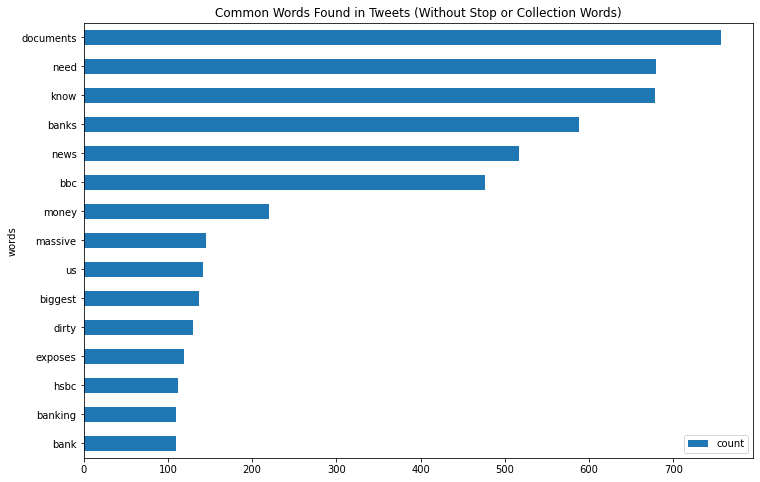

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
clean_tweets_ncw.sort_values(by='count').plot.barh(x='words', y='count', ax=ax)
ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")
plt.show()

In [15]:
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]
bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                         columns = ['bigram', 'count'])
bigram_df.head()

,bigram,count
0,"(need, know)",668
1,"(know, documents)",634
2,"(bbc, news)",464
3,"(news, need)",355
4,"(documents, bbc)",106


In [16]:
d = bigram_df.set_index('bigram').T.to_dict('records')

In [17]:
G = nx.Graph()
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

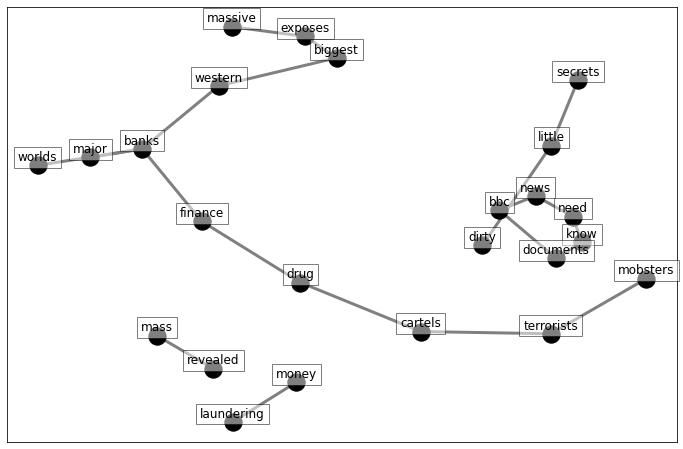

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, k=5)
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='black',
                 with_labels = False,
                 ax=ax)
for key, value in pos.items():
    x, y = value[0], value[1]+0.02
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='White', alpha=0.5),
            horizontalalignment='center', fontsize=12)
plt.show()

In [19]:
sentiment_objects = [TextBlob(tweet) for tweet in all_tweets_no_urls]
sentiment_values = [[tweet.sentiment.polarity, tweet.sentiment.subjectivity, str(tweet)] for tweet in sentiment_objects]

sentiment_df = pd.DataFrame(sentiment_values, columns=['polarity', 'subjectivity', 'tweet'])
sentiment_df.head()

,polarity,subjectivity,tweet
0,0.000,0.0000,465 News FinCEN Files leak and Natwest carbon ...
1,0.000,0.0000,465 News FinCEN files leak and Natwest carbon ...
2,0.225,0.3375,The recent leak of FinCEN files some of the in...
3,0.225,0.4750,CYKLaw CYK partner Philip Young comments to Fi...
4,0.000,0.0000,Fincen files is another leak by the ICIJ In an...


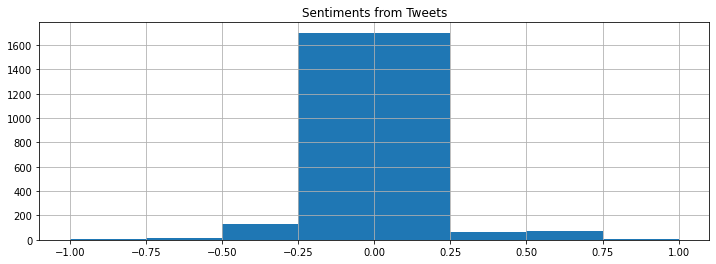

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
bins = [-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1]
sentiment_df['polarity'].hist(bins=bins, ax=ax)
plt.title("Sentiments from Tweets")
plt.show()

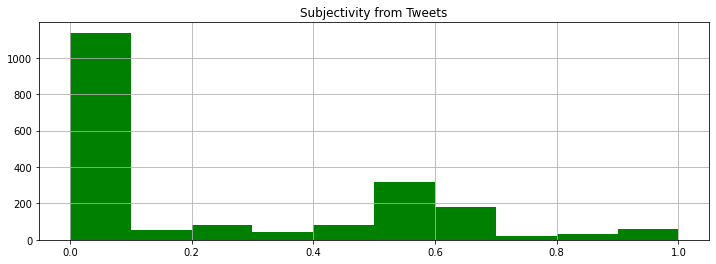

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))
sentiment_df['subjectivity'].hist(color = 'green', ax=ax)
plt.title(r'Subjectivity from Tweets')
plt.show()

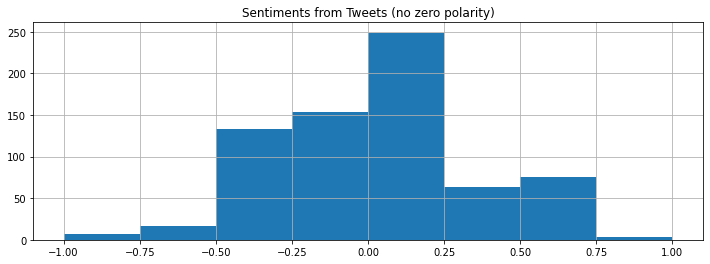

In [22]:
sentiment_df = sentiment_df[sentiment_df.polarity != 0]
fig, ax = plt.subplots(figsize=(12, 4))
bins = [-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1]
sentiment_df['polarity'].hist(bins=bins, ax=ax)
plt.title(r'Sentiments from Tweets (no zero polarity)')
plt.show()

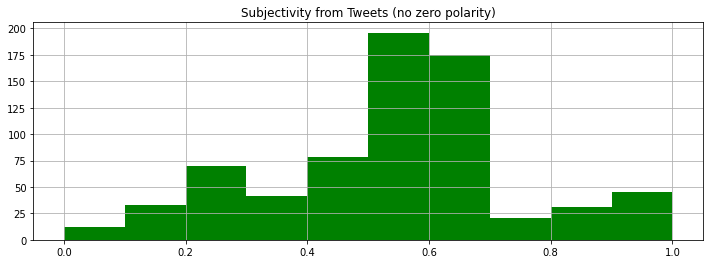

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
sentiment_df['subjectivity'].hist(color = 'green', ax=ax)
plt.title(r'Subjectivity from Tweets (no zero polarity)')
plt.show()

In [27]:
word_string = ' '.join(all_tweets_no_urls)
word_string = word_string.lower()
stopwords = collection_words + list(STOPWORDS)

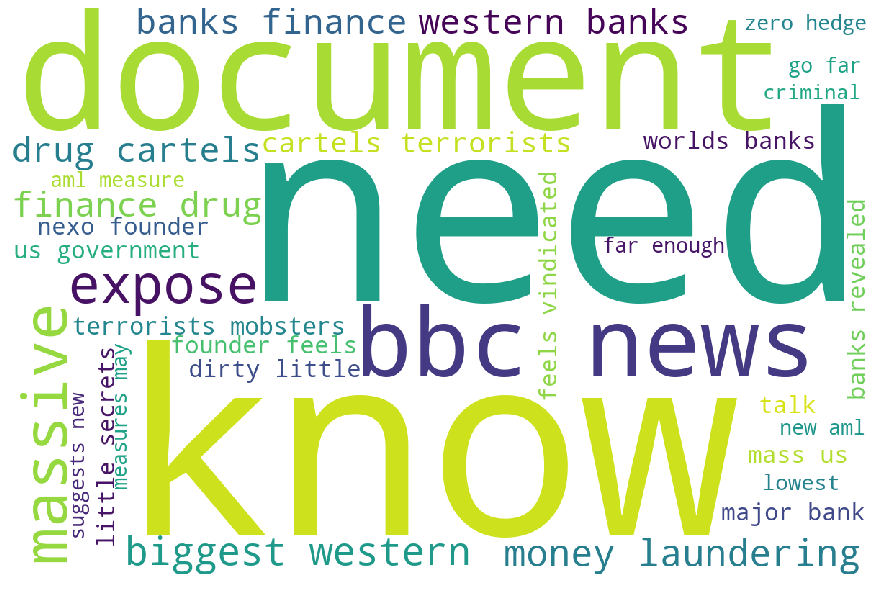

In [28]:
wordcloud = WordCloud(width = 1200, height = 800,
                      background_color = 'white',
                      stopwords = stopwords,
                      min_font_size = 24).generate(word_string)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()